# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [4]:
columb["home_value"] = columb["home.value"]

## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.lin("scale(area)*scale(income) + home_value")
loc += tb.lin("x")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


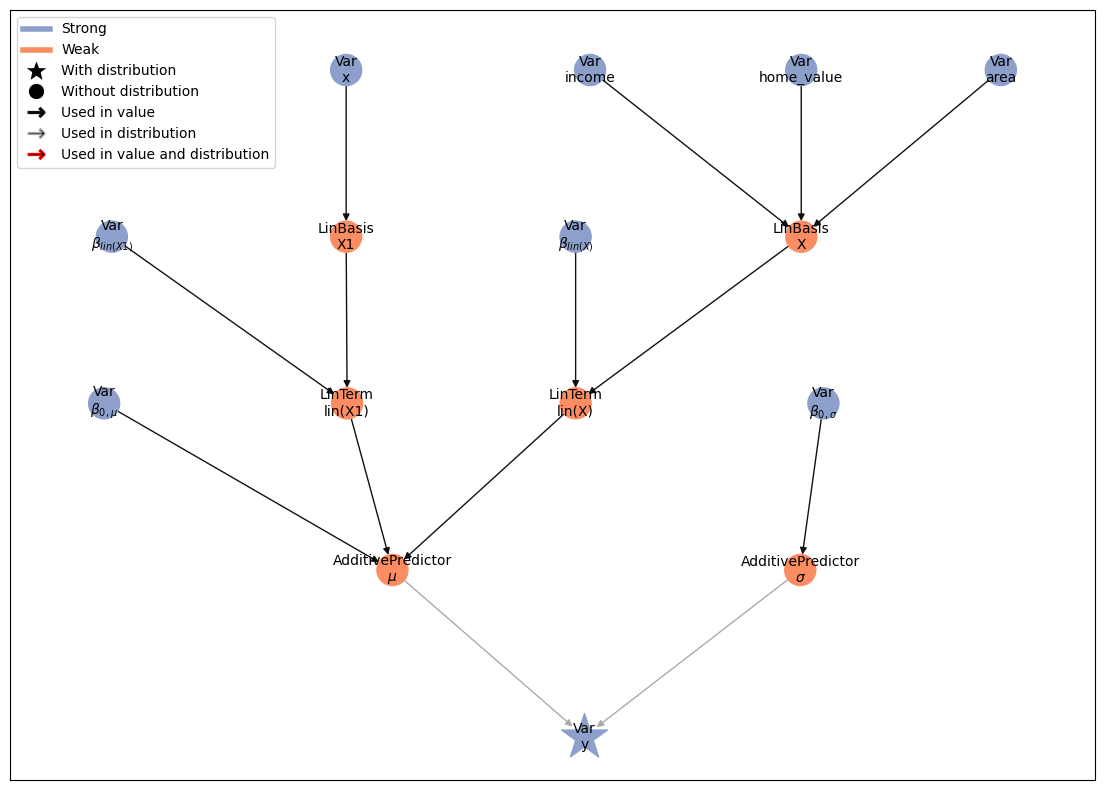

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{lin(X1)}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.05chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.60chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel       mean         sd     q_0.05  \
parameter          index                                               
$\beta_{0,\mu}$    ()     kernel_01  29.681269  14.819593   5.068389   
$\beta_{0,\sigma}$ ()     kernel_00   2.440412   0.109802   2.267094   
$\beta_{lin(X)}$   (0,)   kernel_03  -1.498177   1.923725  -4.627101   
                   (1,)   kernel_03  -9.327487   2.176267 -12.795114   
                   (2,)   kernel_03  -0.280294   0.106199  -0.453952   
                   (3,)   kernel_03   1.638261   1.878797  -1.544619   
$\beta_{lin(X1)}$  (0,)   kernel_02   1.740294   1.578471  -0.885089   

                              q_0.5     q_0.95  sample_size     ess_bulk  \
parameter          index                                                   
$\beta_{0,\mu}$    ()     29.769375  53.421454         4000    68.622428   
$\beta_{0,\sigma}$ ()      2.437286   2.629162         4000  2978.392005   
$\beta_{lin(X)}$   (0,)   -1.505425   1.645962         4000  3587.319043   
                   (1,)   -9.350504  -5.808747         4000  2494.157063   
                   (2,)   -0.281822  -0.104890         4000  1040.686617   
                   (3,)    1.619558   4.698249         4000  1951.278208   
$\beta_{lin(X1)}$  (0,)    1.729014   4.345839         4000    71.751418   

                             ess_tail      rhat  
parameter          index                         
$\beta_{0,\mu}$    ()      278.104548  1.065181  
$\beta_{0,\sigma}$ ()     3325.953081  0.999718  
$\beta_{lin(X)}$   (0,)   3969.992003  1.000833  
                   (1,)   3271.236346  0.999959  
                   (2,)   1982.974392  1.004315  
                   (3,)   2705.333839  1.001643  
$\beta_{lin(X1)}$  (0,)    287.500173  1.062630

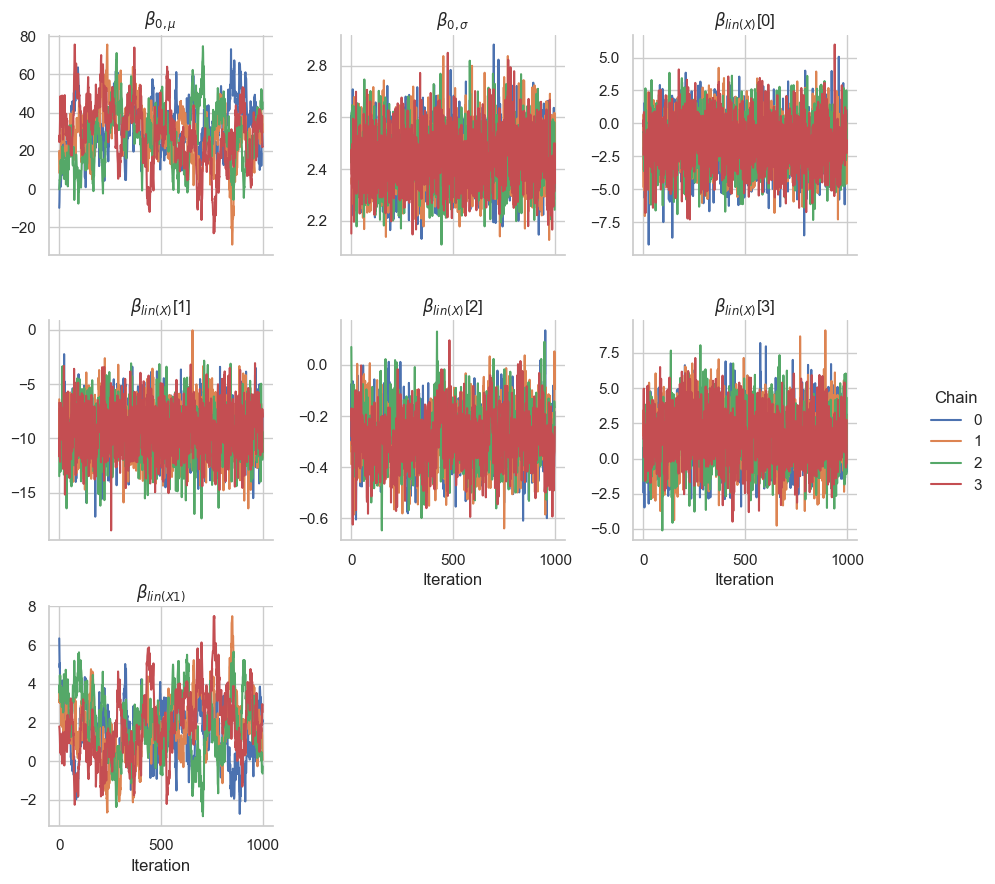

In [10]:
gs.plot_trace(results)

In [11]:
samples = results.get_posterior_samples()

In [12]:
gam.summarise_lin(model.vars["lin(X)"], samples)

,x,sample_size,mean,var,sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,scale(area),4000,-1.498177,3.700718,1.923725,-4.627101,-1.505425,1.645962,-4.620723,1.648175
1,scale(income),4000,-9.327487,4.736140,2.176267,-12.795114,-9.350504,-5.808747,-12.710883,-5.745958
2,home_value,4000,-0.280294,0.011278,0.106199,-0.453952,-0.281822,-0.104890,-0.456660,-0.108961
3,scale(area):scale(income),4000,1.638261,3.529880,1.878797,-1.544619,1.619558,4.698249,-1.299061,4.859503


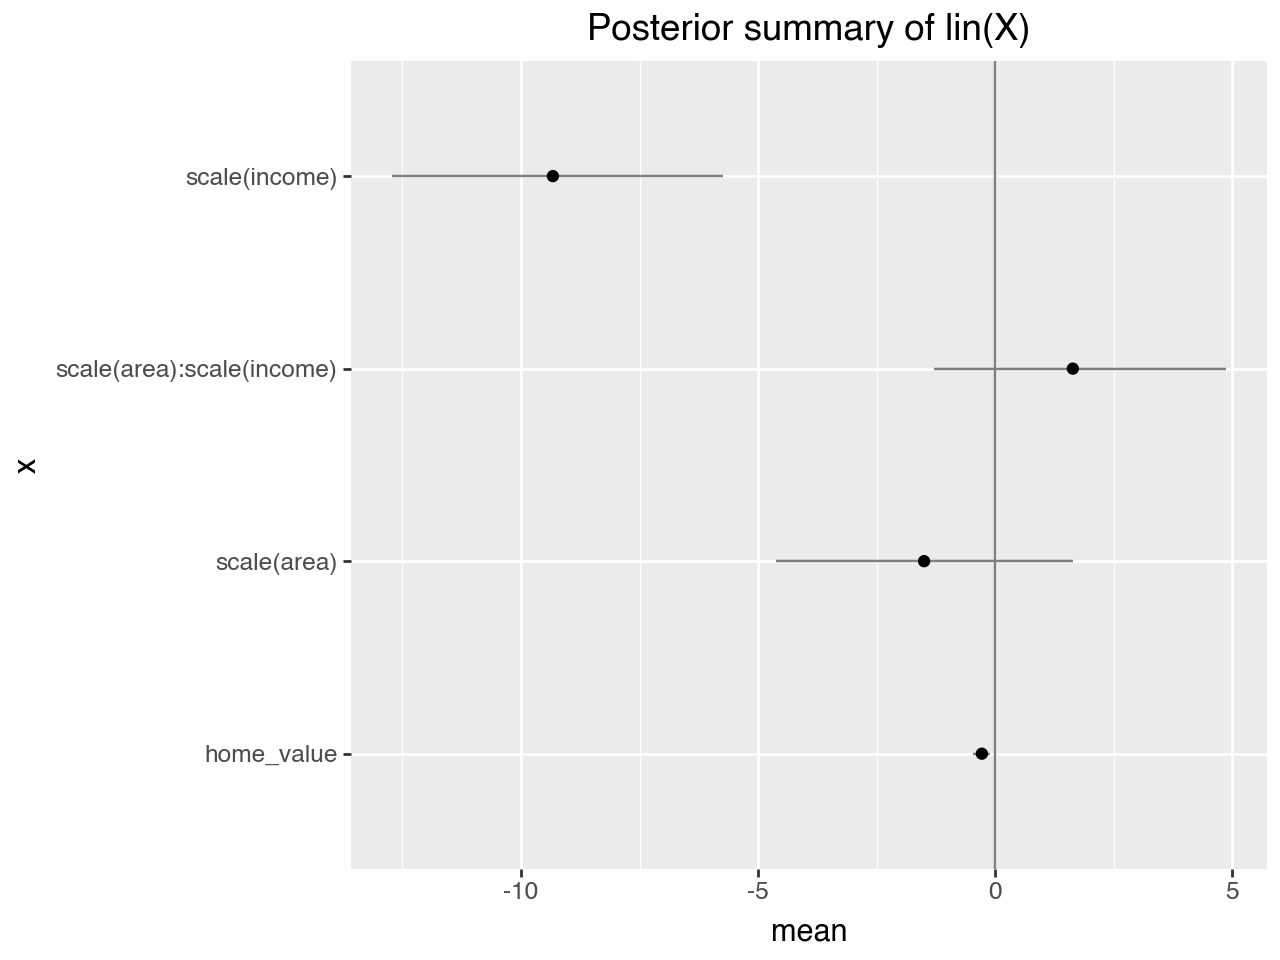

In [13]:
term = model.vars["lin(X)"]
gam.plot_forest(term, samples)